In [1]:
# lets build cifar 10 classifier from scratch
# today's tasks
    # 1. Train on Resnet 18 model
    # 2. use 1 cycle LR policy for fast training
    # 3. Image augmentation to further improve accruacy

# Target: 85% plus test accuracy

In [2]:
# so resnet 18 follows basically this architecture
 # x=  x + Res_block(x)
 # each resblock has 2 convolution layer

# so we will start from 32x32x3
# one prep layer- one conv block 3x3x64 => output size 32x32x32
# each layer containing 2 resblock (conv-relu-batchnorm-conv-relu-batchnorm), first conv of first resblock will be pooling layer with stride of 2 to reduce output size
# we will have total of 4 layers, thus making it 4 * 4  = 16 conv layer
# then we will use pooling (average) and final one fc layer so total of 18 layers
# lets build

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
])

In [3]:
#lets load our dataset, only converting to tensor, we will be adding transformations later
train_data = datasets.CIFAR10('./data', train=True, download=True, transform= train_transforms)

#pin_memory parameter will be useful for GPUs
train_loader_args = {"batch_size": 128, "shuffle":True, "num_workers":2, "pin_memory":True}
train_loader = DataLoader(train_data, **train_loader_args)

Files already downloaded and verified


In [4]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import lightning as L
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


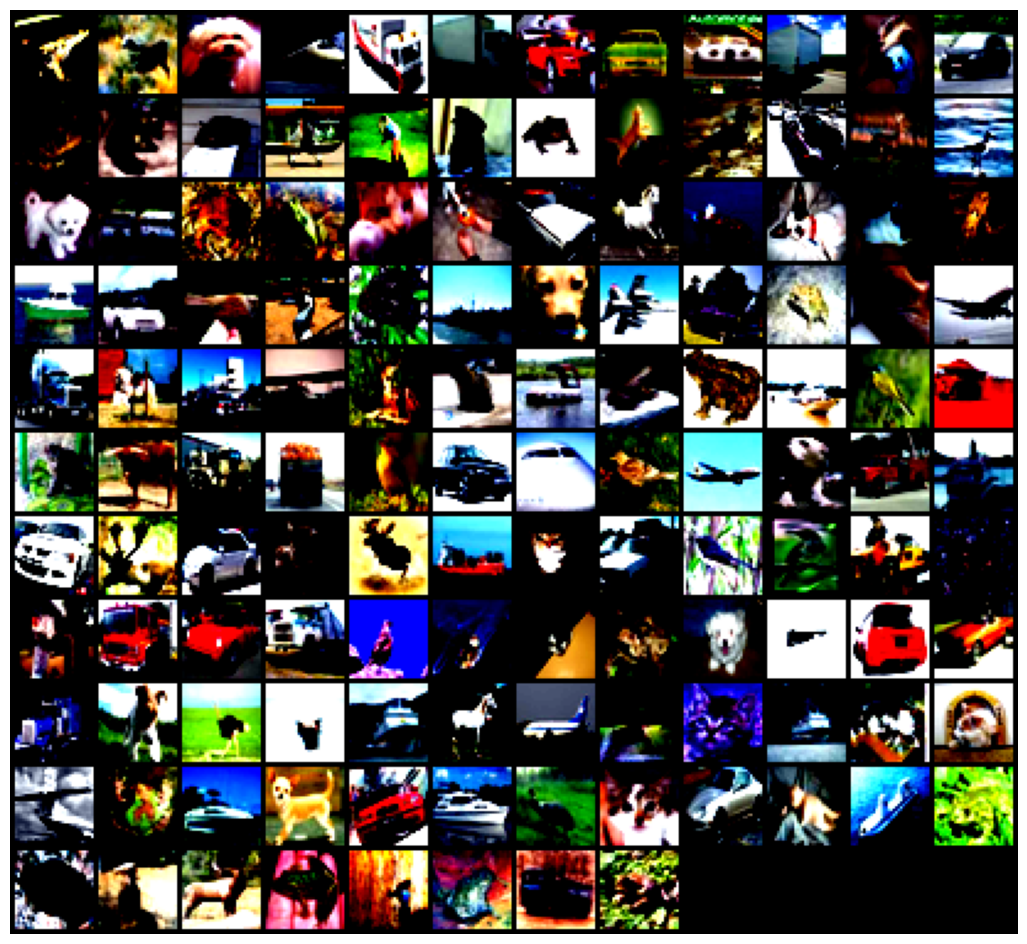

In [5]:
def visualise_dataset(train_loader):
    images, labels = next(iter(train_loader))
    
    combined_image = make_grid(images, nrow=12)
    plt.figure(figsize=(16,12))
    plt.imshow(combined_image.numpy().transpose(1,2,0))
    plt.axis('off')
visualise_dataset(train_loader)

In [6]:
import torch.nn as nn
import torch

In [7]:
test_data = datasets.CIFAR10('./data',download=True, train=False, transform= test_transforms)
test_loader_args = {"batch_size": 128, "shuffle":False, "num_workers":2, "pin_memory":True}
test_loader = DataLoader(test_data, **test_loader_args)

Files already downloaded and verified


In [10]:
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [20]:
import torch.nn as nn
import lightning as L
from torch.optim.lr_scheduler import OneCycleLR

def conv_block(i, o, k, s, p):
    return nn.Sequential(
        nn.Conv2d(i,o,k,s,p),
        nn.ReLU(),
        nn.BatchNorm2d(o),
        nn.Dropout(0.05)
    )

class resblock(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size=3, stride_1=1, stride_2=1, padding_1=1, padding_2=1):
        super().__init__()
        self.conv1 = conv_block(in_channel, out_channel, kernel_size, stride_1, padding_1)
        self.conv2 = conv_block(out_channel, out_channel, kernel_size, stride_2, padding_2)
    def forward(self,x):
        x= self.conv2(self.conv1(x))
        return x

In [12]:
class Resnet_model(L.LightningModule):
    def __init__(self):
        super().__init__()
        # prep layer
        self.prep= nn.Conv2d(3,64,3,1,1) # 32x32x64
        
        #layer1
        self.res_1_1 = resblock(64,64, 3, stride_1=1, padding_1=1)
        self.res_1_2 = resblock(64,64, 3, stride_2=1, padding_2=1) # 32x32x64

        
         #layer2
        self.res_2_1 = resblock(64,128, 3, stride_1=2, padding_1=1) 
        self.res_2_2 = resblock(128,128, 3, stride_2=1, padding_2=1) # 16x16x128

         #layer1
        self.res_3_1 = resblock(128,256, 3, stride_1=2, padding_1=1)
        self.res_3_2 = resblock(256,256, 3, stride_2=1, padding_2=1) # 8x8x128

         #layer1
        self.res_4_1 = resblock(256,512, 3, stride_1=2, padding_1=1)
        self.res_4_2 = resblock(512,512, 3, stride_2=1, padding_2=1) # 4x4x4

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512,10)
    def forward(self,x):
        x = self.prep(x)

        x= self.res_1_1(x)
        x= x+ self.res_1_2(x)

        x= self.res_2_1(x)
        x= x+ self.res_2_2(x)

        x= self.res_3_1(x)
        x= x+ self.res_3_2(x)

        x= self.res_4_1(x)
        x= x+ self.res_4_2(x)

        x=  self.gap(x)
        x= x.view(-1,512)
        x= self.fc(x)

        return x

    def training_step(self, batch, batch_idx):
        images, labels = batch
        output= self.forward(images)
        prediction = output.argmax(axis=1)
        loss= F.cross_entropy(output, labels)
        self.log("train_loss", loss, prog_bar=True)
        accuracy = (prediction.eq(labels).sum().item())*100/len(labels)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return loss
    def validation_step(self,batch,batch_idx):
        images, labels = batch
        output= self.forward(images)
        prediction = output.argmax(axis=1)
        loss= F.cross_entropy(output, labels)
        self.log("test_loss", loss, prog_bar=True)
        accuracy = (prediction.eq(labels).sum().item())*100/len(labels)
        self.log("test_accuracy", accuracy, prog_bar=True)
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01)
        scheduler= OneCycleLR(optimizer, max_lr=5.34E-02, steps_per_epoch=len(train_loader), epochs=20)
        return {'optimizer': optimizer, 
                'lr_scheduler': {
                    'scheduler': scheduler,
                    'interval': 'step'
                }
                }

In [21]:
model = Resnet_model()

 78%|███████▊  | 78/100 [04:25<01:14,  3.41s/it]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 5.34E-02


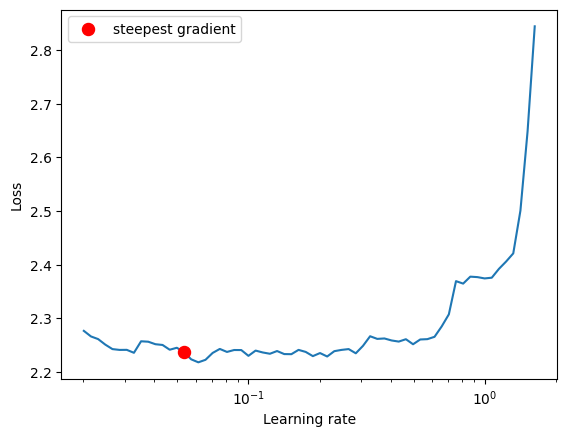

In [19]:


# from torch_lr_finder import LRFinder
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# lr_finder = LRFinder(model, criterion=criterion, optimizer=optimizer)

# lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
# lr_finder.plot()
# lr_finder.reset()

# suggested_LR = 5.34E-02



In [22]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
              ReLU-3           [-1, 64, 32, 32]               0
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,928
              ReLU-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
           Dropout-9           [-1, 64, 32, 32]               0
         resblock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,928
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
          Dropout-14           [-1, 64,

In [15]:
trainer = L.Trainer(max_epochs=5) # it reduces the training time

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
trainer.fit(model, train_loader, test_loader)

Missing logger folder: /Users/hemant/Documents/Cifar_10_classifier/lightning_logs

   | Name    | Type              | Params
-----------------------------------------------
0  | prep    | Conv2d            | 1.8 K 
1  | res_1_1 | resblock          | 74.1 K
2  | res_1_2 | resblock          | 74.1 K
3  | res_2_1 | resblock          | 221 K 
4  | res_2_2 | resblock          | 295 K 
5  | res_3_1 | resblock          | 886 K 
6  | res_3_2 | resblock          | 1.2 M 
7  | res_4_1 | resblock          | 3.5 M 
8  | res_4_2 | resblock          | 4.7 M 
9  | gap     | AdaptiveAvgPool2d | 0     
10 | fc      | Linear            | 5.1 K 
-----------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
44.016    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1:  34%|███▎      | 131/391 [00:42<01:24,  3.06it/s, v_num=0, train_loss=1.070, train_accuracy=55.50, test_loss=1.360, test_accuracy=52.20]

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [16]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 10696), started 18:18:42 ago. (Use '!kill 10696' to kill it.)

In [56]:
import gradio as gr

In [57]:
train_data.cl

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [19]:
# i got the issue, we are not resizing it
import numpy as np
import gradio as gr

/Users/hemant/Documents/Cifar_10_classifier/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
from PIL import Image

def resize_image(image):
    img = Image.fromarray(image)
    img = img.resize((32,32))
    return img

def predict(image):
    img = resize_image(image)

    img_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, .4468), (0.2470, 0.2435, 0.2616))
    ])

    img = img_transforms(img)

    img = img.unsqueeze(0)

    output= model(img)

    # Make prediction
    prediction = output.argmax(axis=1)

    # Assuming train_data.classes is a list of class names
    return train_data.classes[prediction.item()]


In [35]:
interface = gr.Interface(fn=predict, 
                         inputs=[gr.Image()], 
                         outputs=["text"])
interface.launch()

Running on local URL:  http://127.0.0.1:7885

To create a public link, set `share=True` in `launch()`.


In [ ]:
#our model needs to be better trained, currently is has accuracy of about 40-50%, we will try to do it in next session, thanks

In [ ]:
# i hope it gives better result this time